This function mainly use two package: `scipy.signal.find_peaks` and `lmfit`.

You may need the [documentation of `lmfit`](https://lmfit.github.io/lmfit-py/index.html). This package use the least square method to fit the data. It gives beatuful fitting reports and build-in models including linear models many peak functions, which can get initial values automatically by `parameters.guess()`. And it allows you to combine different models together.

In [49]:
# the peak_fitting function written in peak_fitting.py
def peak_fitting(data,prominence,xdata = None ,peak_type='gaussian',
                plotting = True, ax = None, datafmt='-', fitfmt='-',
                **peakfinding_params):
    '''
    data: 1D array, the data to be fitted
    prominence: float, the prominence of peaks, used by scipy.find_peaks()
    xdata: 1D array, the x-axis data, default is None, if None, use np.arange(len(data))
    peak_type: str, the type of peak to be fitted, default is 'gaussian', options are 'gaussian', 'lorentzian', 'voigt'
    peakfinding_params: dict, parameters used by scipy.find_peaks()

    ax: matplotlib.axes.Axes, the axes to plot the data and peaks, default is None, if None, create a new figure
    datafmt: str, the format of data plot, default is '-' but other people prefer 'o'
    fitfmt: str, the format of fitted data plot, default is '-'

    return:
        if plotting == True:
            return the lmfit.model.ModelResult object, the result of the fitting
        else:
            return a tuple, the lmfit.model.ModelResult object and ax.
    '''
    import numpy as np
    from scipy.signal import find_peaks
    if xdata == None:
        xdata = np.arange(len(data))
    peaks,info = find_peaks(data,prominence=prominence,**peakfinding_params)
    # print(peaks)
    peak_number = len(peaks)
    corrected_left_bases = []
    corrected_right_bases = []
    for i in range(peak_number):
        # Left_bases correction
        if i>0:
            if info['left_bases'][i]<peaks[i-1]:
                corrected_left_bases.append(info['right_bases'][i-1])
            else:
                corrected_left_bases.append(info['left_bases'][i])
        else:
            corrected_left_bases.append(info['left_bases'][i])
        # Right_bases correction
        if i<peak_number-1:
            if info['right_bases'][i]>peaks[i+1]:
                corrected_right_bases.append(info['left_bases'][i+1])
            else:
                corrected_right_bases.append(info['right_bases'][i])
        else:
            corrected_right_bases.append(info['right_bases'][i])
    corrected_left_bases = np.array(corrected_left_bases)
    corrected_right_bases = np.array(corrected_right_bases)


    if peak_type[0] in ['g','G']:
        from lmfit.models import GaussianModel
        peak_models = [GaussianModel(prefix=f'G{i}_') for i in range(peak_number)]
    elif peak_type[0] in ['l','L']:
        from lmfit.models import LorentzianModel
        peak_models = [LorentzianModel(prefix=f'L{i}_') for i in range(peak_number)]
    elif peak_type[0] in ['v','V']:
        from lmfit.models import VoigtModel
        peak_models = [VoigtModel(prefix=f'V{i}_') for i in range(peak_number)]
    total_model = peak_models[0]
    for i in range(1,peak_number):
        total_model += peak_models[i]

    from lmfit import Parameters
    params = Parameters()
    for i in range(peak_number):
        params.update(peak_models[i].guess(data[corrected_left_bases[i]:corrected_right_bases[i]],
                                           xdata[corrected_left_bases[i]:corrected_right_bases[i]]))
    if peak_type[0] in ['v','V']:
        for i in range(peak_number):
            params[f'V{i}_gamma'].set(value = 0.7,vary=True,min = 0)

    fitresult = total_model.fit(data,params,x=xdata)

    if plotting:
        print(f'{peak_number} peaks found.')
        if ax == None:
            ax = fitresult.plot_fit(datafmt = '-')
        else:
            fitresult.plot_fit(ax=ax,datafmt = '-')
        return fitresult,ax
    return fitresult

# Examples

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme('poster')
%config InlineBackend.figure_format = 'retina'

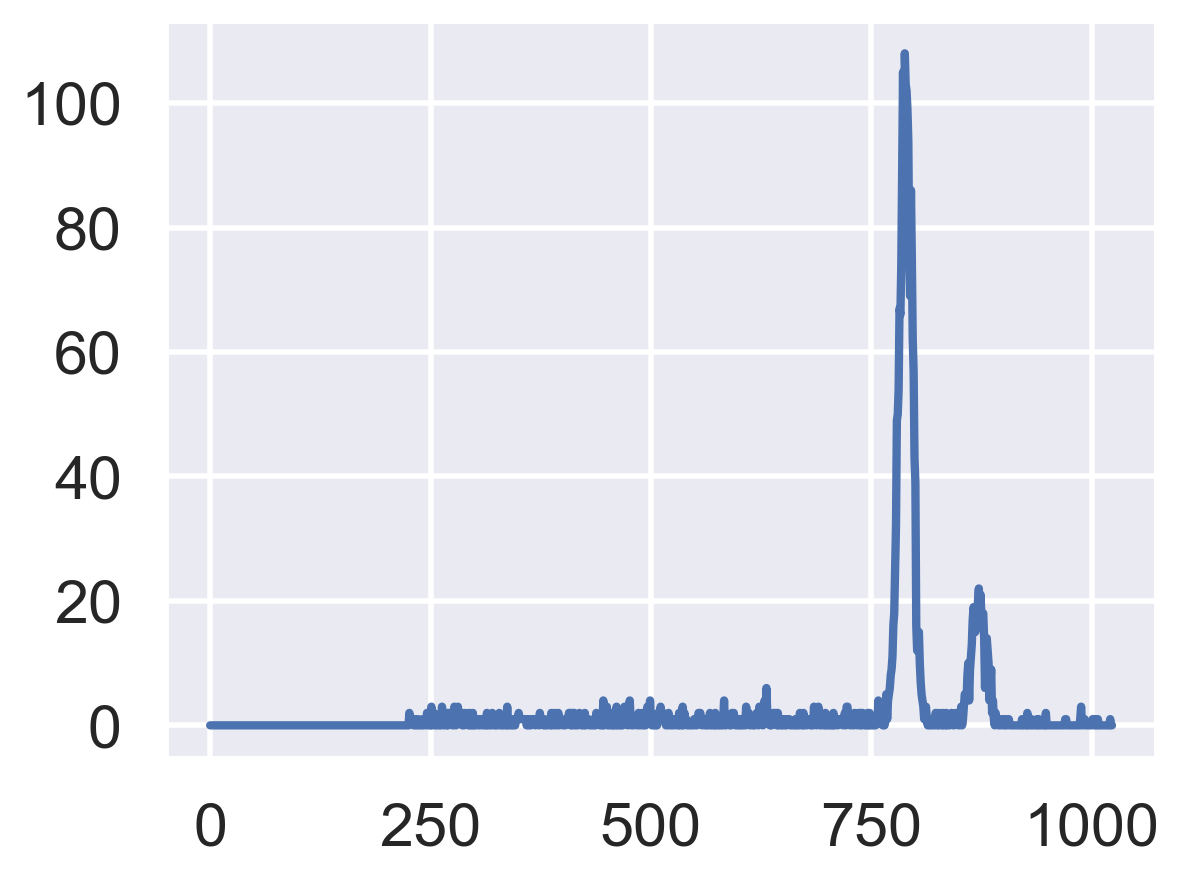

In [51]:
# the data extracter for a .mca file

def open_mca_data(file_name):
    import numpy as np
    with open(file_name, 'r', encoding='ansi') as file:
        content = file.readlines()
    data = False
    datas = []
    for i in content:
        if i =='<<END>>\n':
            data = False
        if data:
            datas.append(eval(i))
        if i =='<<DATA>>\n':
            data = True
    datas = np.array(datas)
    return datas
data = open_mca_data(r'raw_data\Cu25_6.mca')
plt.plot(data)
plt.show()

If you choose plotting to be `True`, the function returns a tuple of `lmfit.result` and `matplotlib.axes.Axes` objects.

2 peaks found.
[[Model]]
    (Model(voigt, prefix='V0_') + Model(voigt, prefix='V1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 1024
    # variables        = 8
    chi-square         = 2635.72291
    reduced chi-square = 2.59421546
    Akaike info crit   = 984.131549
    Bayesian info crit = 1023.58332
    R-squared          = 0.98066877
[[Variables]]
    V0_amplitude:  1911.09187 +/- 19.3344716 (1.01%) (init = 3888)
    V0_center:     789.111451 +/- 0.04592618 (0.01%) (init = 790)
    V0_sigma:      7.21592423 +/- 0.13494524 (1.87%) (init = 5.2)
    V0_gamma:      0.34891096 +/- 0.22144172 (63.47%) (init = 0.7)
    V0_fwhm:       17.3682173 +/- 0.12393324 (0.71%) == '1.0692*V0_gamma+sqrt(0.8664*V0_gamma**2+5.545083*V0_sigma**2)'
    V0_height:     101.701481 +/- 0.56995659 (0.56%) == '(V0_amplitude/(max(1e-15, V0_sigma*sqrt(2*pi))))*real(wofz((1j*V0_gamma)/(max(1e-15, V0_sigma*sqrt(2)))))'
    V1_amplitude:  435.647610 +/

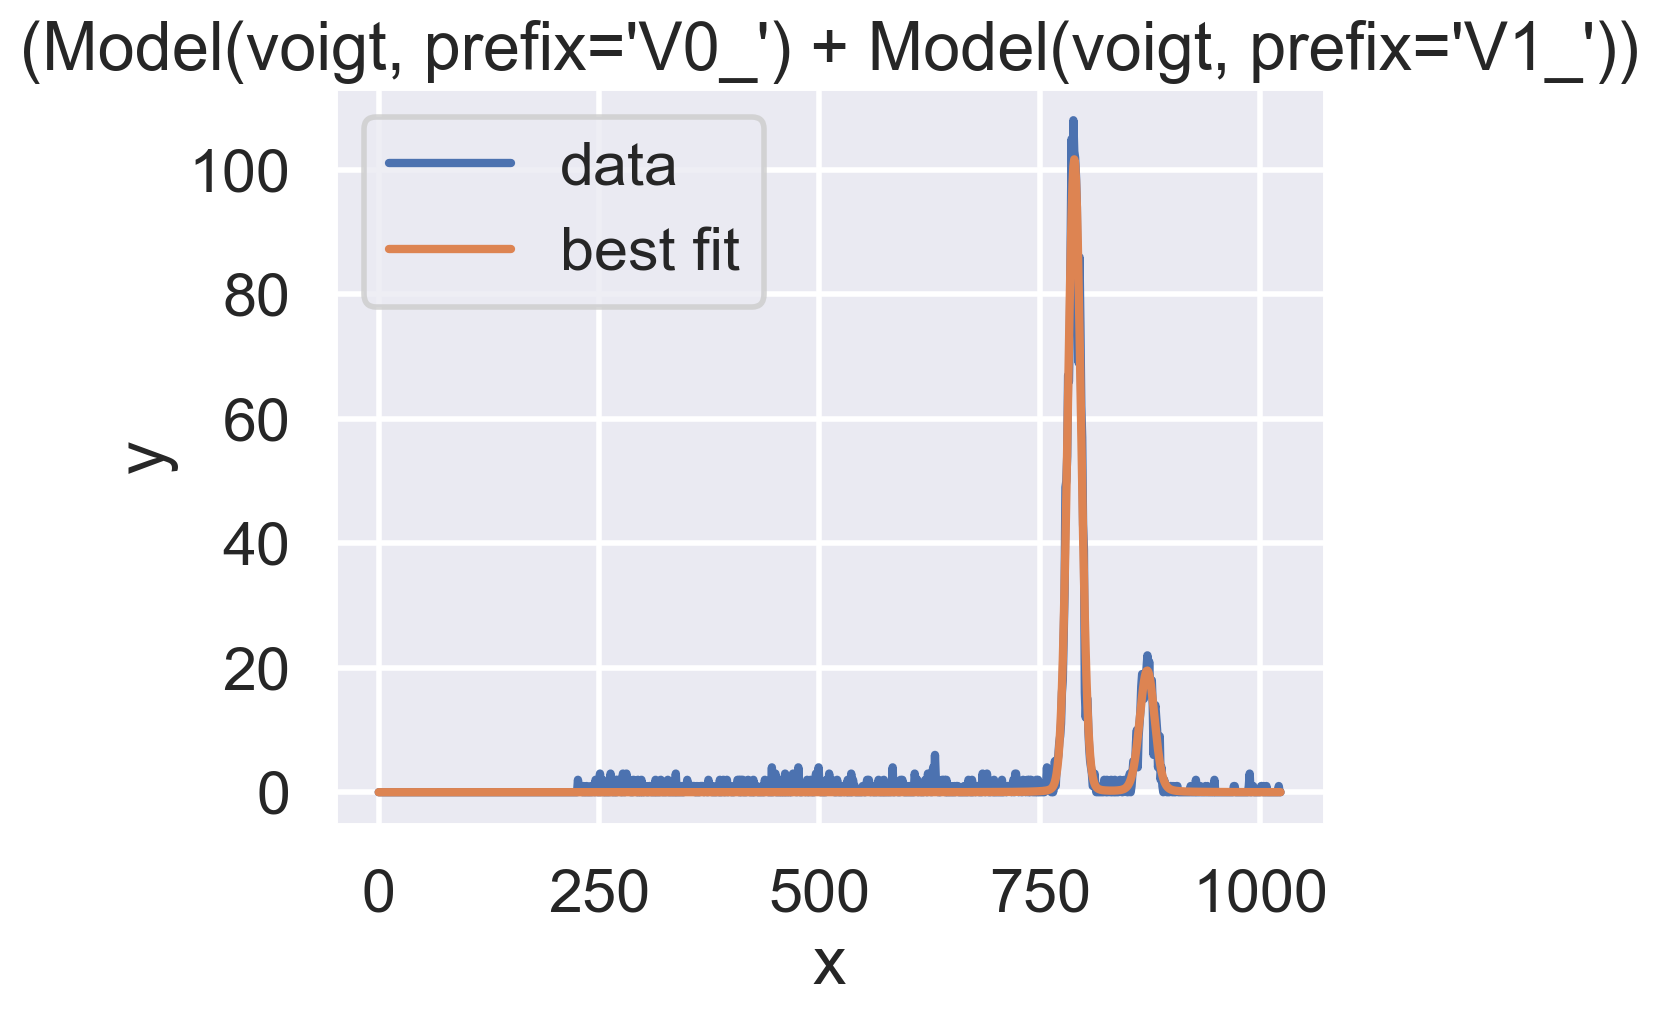

In [52]:
fitting_result, ax = peak_fitting(data, prominence=20,width = 10,peak_type='V')
fig = ax.get_figure()
print(fitting_result.fit_report())

You may feel that the default plotting style is boring, you can adjust it yourself.

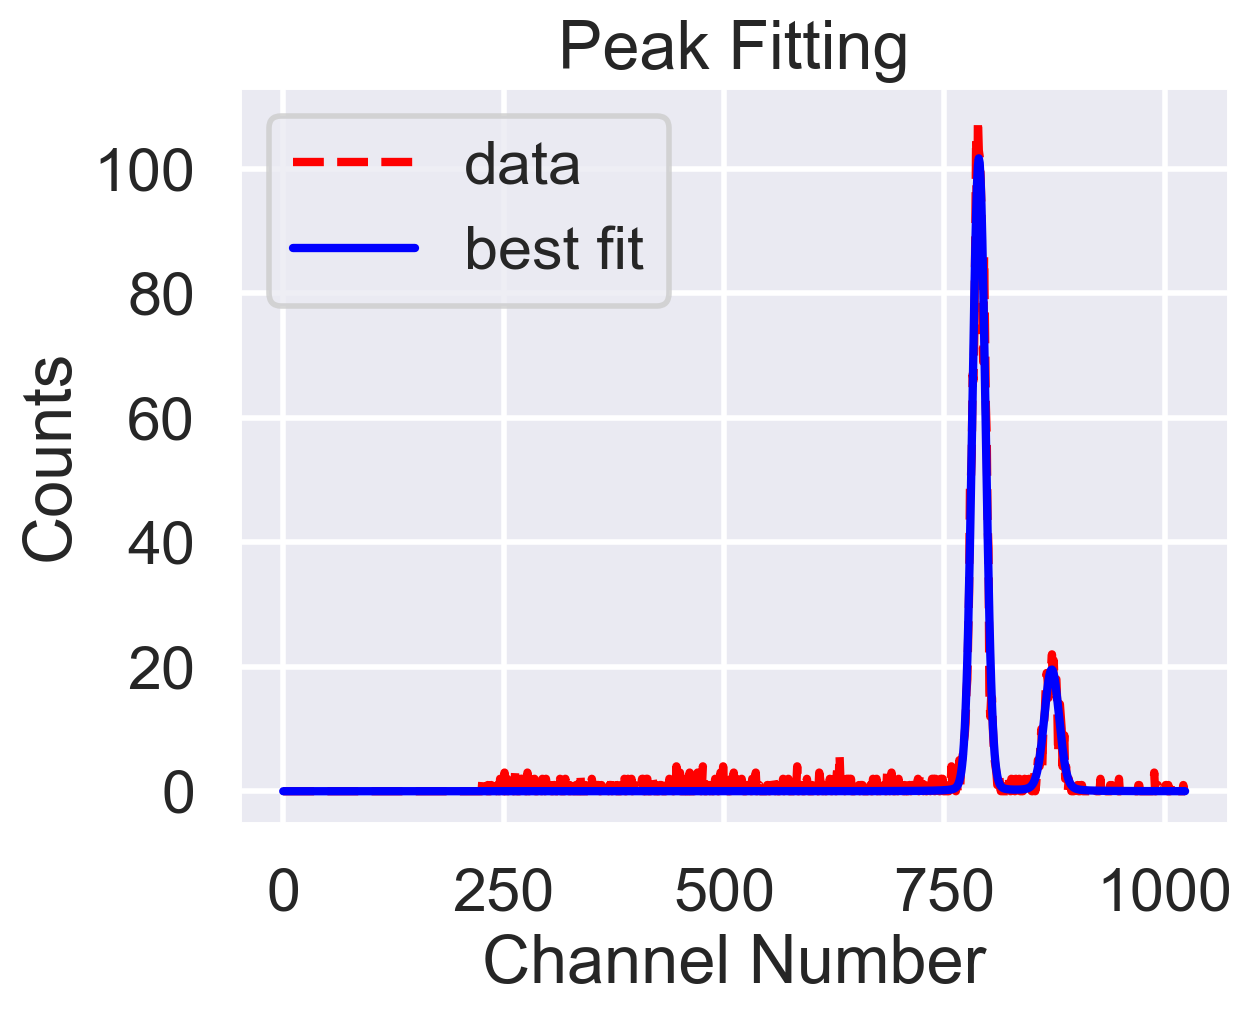

In [53]:
ax.lines[0].set_linestyle('--')
ax.lines[0].set_color('red')
ax.lines[1].set_color('blue')
ax.set_xlabel('Channel Number')
ax.set_ylabel('Counts')
ax.set_title('Peak Fitting')
ax.legend()
fig